## Fonction de backtest - Stratégie Moyennes Mobiles

Nous allons créer ci-dessous une classe **UnderlyingAnalysis**, et une méthode associée **moving_average_strategy** qui, à partir du ticker du sous-jacent que l'on désire *trader*, nous fournit les graphiques des **moyennes mobiles** de la performance du sous-jacent, et de la comparaison des rendements respectifs d'une stratégie *long bias*, et d'une stratégie *buy & hold*. Elle nous permet également de comparer la moyenne et l'écart-type des rendements des deux stratégies.

Plus précisément, chaque objet de la classe prend en argument le ticker du sous-jacent et les dates de début et de fin de la période à analyser, télécharge toutes les données disponibles sur YahooFinance, demande la méthode de moyennes mobiles à appliquer entre SMA (Moyennes mobiles simples) et EMA (Moyennes mobiles exponentielles), et enfin demande le nombre d'observations à prendre en compte dans les moyennes mobiles (une moyenne mobile utilisant moins de données, plus sensible aux variations récentes du sous-jacent ; une en utilisant plus, reflétant la tendance de la série).

Pour ce faire, nous aurons besoin des bibliothèques *pandas*, *numpy*, *matplotlib.pyplot* et *yfinance*.

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


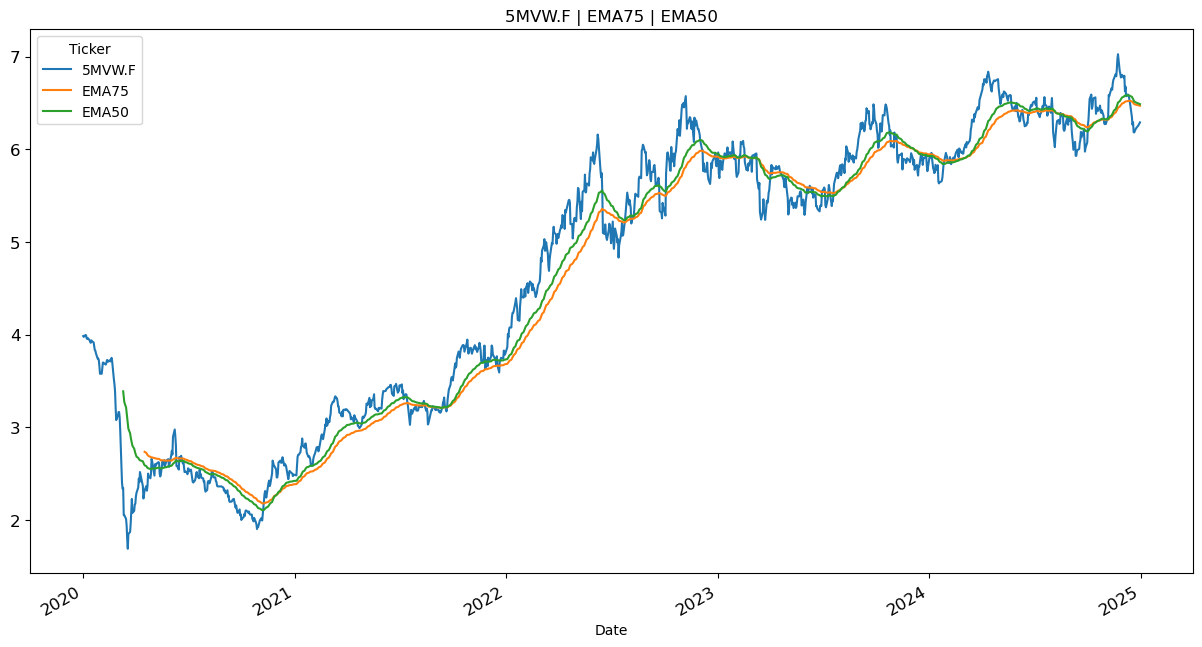

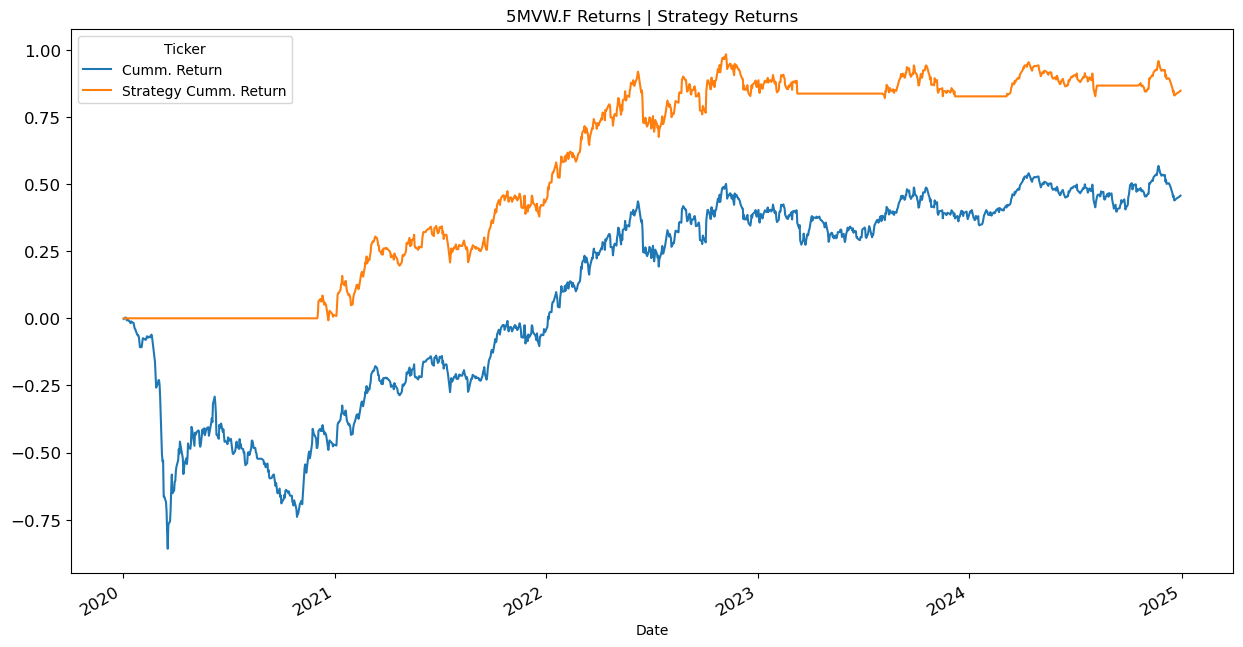

Le rendement du sous-jacent est de  0.4566801788848572
Son écart-type est de  0.019427503876124012
Le rendement de la stratégie est de  0.8473834175437284
Son écart-type est de  0.013296988015789908


Ticker,5MVW.F,Return,Cumm. Return,EMA75,EMA50,Strategy Position,Strategy Return,Strategy Cumm. Return
Date,,,,,,,,
2020-01-02,3.983978,NaN,NaN,NaN,NaN,0,NaN,NaN
2020-01-03,3.974849,-0.002294,-0.002294,NaN,NaN,0,-0.000000,0.000000
2020-01-06,3.996013,0.005310,0.003016,NaN,NaN,0,0.000000,0.000000
2020-01-07,3.992278,-0.000935,0.002081,NaN,NaN,0,-0.000000,0.000000
2020-01-08,3.959079,-0.008351,-0.006269,NaN,NaN,0,-0.000000,0.000000
...,...,...,...,...,...,...,...,...
2024-12-19,6.185000,-0.016993,0.439846,6.495785,6.530046,1,-0.016993,0.830549
2024-12-20,6.181000,-0.000647,0.439199,6.487501,6.516358,1,-0.000647,0.829902
2024-12-23,6.224000,0.006933,0.446132,6.480567,6.504893,1,0.006933,0.836835


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

class UnderlyingAnalysis:

    def __init__(self, ticker, start, end):
        self.ticker = ticker
        self.start = start
        self.end = end

    def moving_average_strategy(self):
        plt.close()
        df = yf.download(self.ticker, self.start, self.end).Close              ## Téléchargement des données à partir de YahooFinance
        df["Return"] = np.log(df[self.ticker].div(df[self.ticker].shift(1)))   ## Calcul des rendements logarithmiques du sous-jacent
        df["Cumm. Return"] = df.Return.cumsum()                                ## Calcul des rendements logarithmiques cumulés du sous-jacent (buy & hold)
        method = input("Which moving averages method do you wish to use? (SMA/EMA)\n")
        while method.lower() not in ["sma", "ema"]:
            method = input("Please enter SMA or EMA following the method you wish to use.\n")
        sample_l = 0
        sample_s = 0
        sample_l = input ("Which window do you want to use for the longer moving averages? Please enter an integer greater than 2.\n")
        while not sample_l.isdigit() or int(sample_l) <= 2:
            sample_l = input ("Please enter an integer greater than 2.\n")
        sample_s = input ("Which window do you want to use for the shorter moving averages? Please enter an integer greater than the previous one.\n")
        while not sample_s.isdigit() or int(sample_s) >= int(sample_l):
            sample_s = input ("Please enter an integer greater than the previous one.\n")
        if method.lower() == "sma":
            df["SMA{}".format(sample_l)] = df[self.ticker].rolling(window = int(sample_l), min_periods = int(sample_l)).mean()     ## Calcul des moyennes mobiles simples
            df["SMA{}".format(sample_s)] = df[self.ticker].rolling(window = int(sample_s), min_periods = int(sample_s)).mean()     
            df["Strategy Position"] = np.where(df["SMA{}".format(sample_l)] <= df["SMA{}".format(sample_s)], 1, 0)   ## Position longue lorsque moyennes mobiles "longues" inférieures à moyennes mobiles "courtes"; sinon position neutre
            df["Strategy Return"] = df["Return"].mul((df["Strategy Position"]).shift(1))     ## Calcul des rendements de la stratégie
            df["Strategy Cumm. Return"] = df["Strategy Return"].cumsum()     ## Calcul des rendements cumulés de la stratégie
            df.loc[:,[f"{self.ticker}", f"SMA{sample_l}", f"SMA{sample_s}"]].plot(figsize = (15, 8), fontsize = 12, 
                                                                 title = f"{self.ticker} | SMA{sample_l} | SMA{sample_s}")     ## Graphique
            df.loc[:,["Cumm. Return", "Strategy Cumm. Return"]].plot(figsize = (15, 8), fontsize = 12, 
                                                                 title = f"{self.ticker} Returns | Strategy Returns")
        else:
            df["EMA{}".format(sample_l)] = df[self.ticker].to_frame().ewm(span = int(sample_l), min_periods = int(sample_l)).mean()   ## Calcul des moyennes mobiles exponentielles, puis sur le même modèle que ci-dessus
            df["EMA{}".format(sample_s)] = df[self.ticker].to_frame().ewm(span = int(sample_s), min_periods = int(sample_s)).mean()
            df["Strategy Position"] = np.where(df["EMA{}".format(sample_l)] <= df["EMA{}".format(sample_s)], 1, 0)
            df["Strategy Return"] = df["Return"].mul((df["Strategy Position"]).shift(1))
            df["Strategy Cumm. Return"] = df["Strategy Return"].cumsum()
            df.loc[:,[f"{self.ticker}", f"EMA{sample_l}", f"EMA{sample_s}"]].plot(figsize = (15, 8), fontsize = 12, 
                                                                 title = f"{self.ticker} | EMA{sample_l} | EMA{sample_s}")
            df.loc[:,["Cumm. Return", "Strategy Cumm. Return"]].plot(figsize = (15, 8), fontsize = 12, 
                                                                 title = f"{self.ticker} Returns | Strategy Returns")
        plt.show()
        print("Le rendement du sous-jacent est de ", df.Return.sum())                 ## Détail des caractéristiques des rendements de la stratégie MA et de la stratégie buy & hold
        print("Son écart-type est de ", df.Return.std())
        print("Le rendement de la stratégie est de ", df["Strategy Return"].sum())
        print("Son écart-type est de ", df["Strategy Return"].std())
        return df

energy_benchmark = UnderlyingAnalysis("5MVW.F", "2020-01-01", "2025-01-01")
energy_benchmark.moving_average_strategy()